In [1]:
import py4DSTEM
import matplotlib.pyplot as plt
import numpy as np
import pathlib
import pandas as pd
import seaborn as sns
import re
import h5py

from functools import reduce
from ttt.utils import listfiles
from mlr.database.utils import read_metadata, write_metadata
from matplotlib import cm

In [2]:
def read_training_history(path):
    history_file = h5py.File(path,'r')
    history_dict = {x:np.array(y) for x, y in history_file.items()} 
    history_file.close()
    return history_dict

In [3]:
root_dir_base = pathlib.Path("/media/files/segmentation_networks/")
root_dirs = [root_dir_base.joinpath("baseline_small_datasets_HQ_redux_1_6_2022"),
            root_dir_base.joinpath("small_NP_networks_redux_1_6_2022"),
            root_dir_base.joinpath("substrate_networks_redux_1_7_2022"),
            root_dir_base.joinpath("super_network_1_25_2022"),
            root_dir_base.joinpath("transfer_learning_redux_1_10_2022"),
            root_dir_base.joinpath("transfer_learning_1_30_2022"),
            ]

root_dirs = [folder.joinpath("trained_models") for folder in root_dirs]
model_folders = [[x for x in listfiles(r) if x.is_dir()] for r in root_dirs]
model_folders = reduce(lambda x,y: x+y, model_folders)

In [4]:
## load all the metadata from the networks
metadata_list = []
for folder in model_folders:
    model_metadata = read_metadata(folder.joinpath("metadata.json"))    
    model_id = re.search("[0-9]+_[0-9]+", str(folder).rsplit("/")[-1])[0]
    model_metadata["ID"] = model_id
    if "transfer" in str(folder):
        tl = True
        history_path = "sm_unet_transferLearnWeights_" + model_metadata["backbone"]+"_history.h5"
        history_dict = read_training_history(folder.joinpath(history_path))
        # model_metadata.update(history_dict)
        model_metadata["best_val_f1"] = history_dict["val_f1-score"][np.argmin(history_dict["val_loss"])]
        model_metadata["series"] = "transfer"
    else:
        tl = False
        model_metadata["series"] = str(folder).rsplit("/")[-3].split("_")[0]
    model_metadata["transfer_learned"] = tl
    model_metadata["folder"] = folder
    metadata_list.append(model_metadata)
        
df = pd.DataFrame(metadata_list)
df = pd.concat([df, pd.DataFrame(df['schedule'].to_list(), columns = ['schedule_rate', 'schedule_timing'])], axis=1)

(0.2, 1.0)

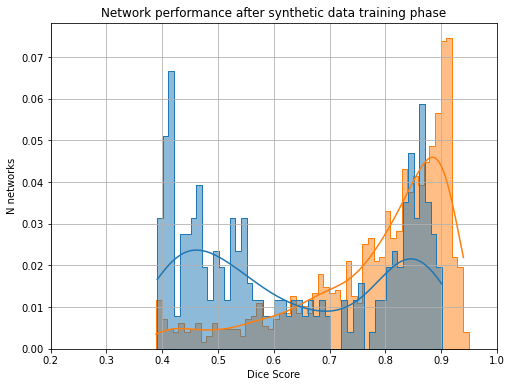

In [5]:
fig = plt.figure(figsize=(8,6))

style_args = {"kde":True,
              "binwidth":0.01,
              "stat":"probability",
              "element":"step"}
ax = sns.histplot(data=df[df["transfer_learned"]==True], x="best_val_f1", color=cm.get_cmap("tab10")(1), **style_args)
ax = sns.histplot(data=df[df["transfer_learned"]==False], x="exp_f1-score", **style_args)

ax.set_title("Network performance after synthetic data training phase")
ax.set_ylabel("N networks")
ax.set_xlabel("Dice Score")
ax.grid()
ax.set_xlim([0.2, 1.0])

(0.2, 1.0)

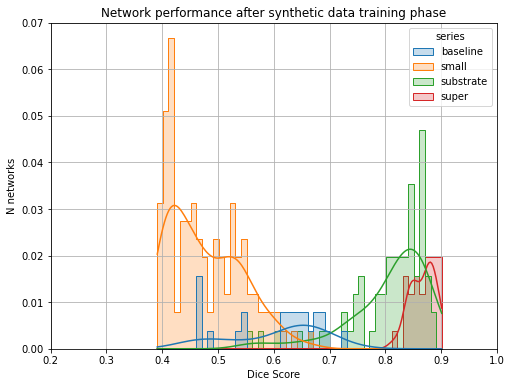

In [6]:
fig = plt.figure(figsize=(8,6))

style_args = {"kde":True,
              "binwidth":0.01,
              "stat":"probability",
              "element":"step"
              }
ax = sns.histplot(data=df[df["transfer_learned"]==False], x="exp_f1-score", hue="series",**style_args)

ax.set_title("Network performance after synthetic data training phase")
ax.set_ylabel("N networks")
ax.set_xlabel("Dice Score")
ax.grid()
ax.set_xlim([0.2, 1.0])

In [7]:
baseline_IDs = list(df[df["series"]=="baseline"]["ID"])
small_IDs = list(df[df["series"]=="small"]["ID"])
sub_IDs = list(df[df["series"]=="substrate"]["ID"])
super_IDs =  list(df[df["series"]=="super"]["ID"])

In [80]:
scatter_dicts = []

# each dict needs: series, x_dice, y_dice, expt_val_split

for ids in [baseline_IDs, small_IDs, sub_IDs]:
    for i, row in df[df["orig_model_ID"].isin(ids)].iterrows():
        data_dict = {}
        data_dict["y_dice"] = row["best_val_f1"]
        data_dict["split"] = row["expt_val_split"]
        data_dict["x_dice"] = df[df["ID"]==row["orig_model_ID"]]["exp_f1-score"].values[0]
        data_dict["d_series"] = df[df["ID"]==row["orig_model_ID"]]["series"].values[0]
        scatter_dicts.append(data_dict)

scatter_df = pd.DataFrame(scatter_dicts)

<AxesSubplot:xlabel='Exp. Dice Score after Synthetic Training', ylabel='Exp. Dice Score after Transfer Learning'>

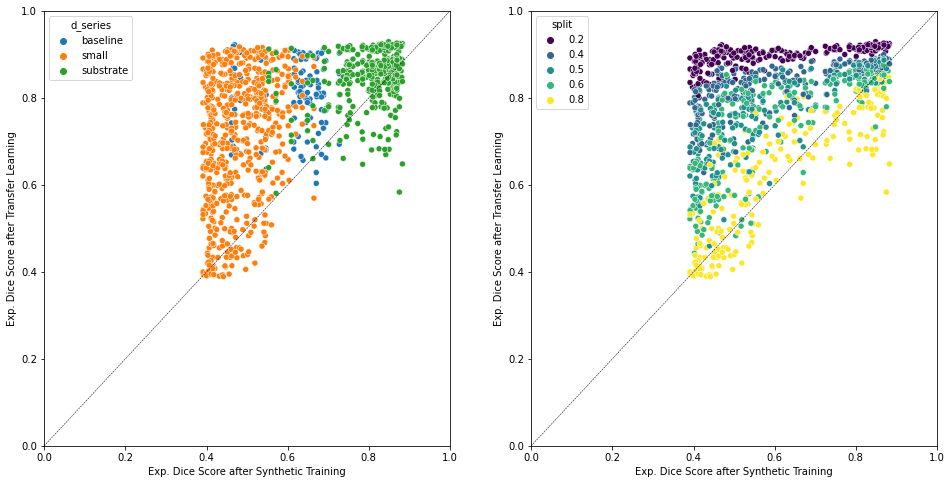

In [113]:
fig, axes = plt.subplots(1,2,figsize=(16,8))

for ax in axes:
    ax.set_xlabel("Exp. Dice Score after Synthetic Training")
    ax.set_ylabel("Exp. Dice Score after Transfer Learning")
    ax.set_xlim([0,1])
    ax.set_ylim([0,1])
    ax.plot([0,1],[0,1], linestyle="--", linewidth=0.5,color="k")
    
sns.scatterplot(data=scatter_df, x="x_dice", y='y_dice', hue="d_series", ax=axes[0])
sns.scatterplot(data=scatter_df, x="x_dice", y='y_dice', hue="split", palette="viridis",ax=axes[1])


Text(0, 0.5, 'Exp. Dice Score after Transfer Learning')

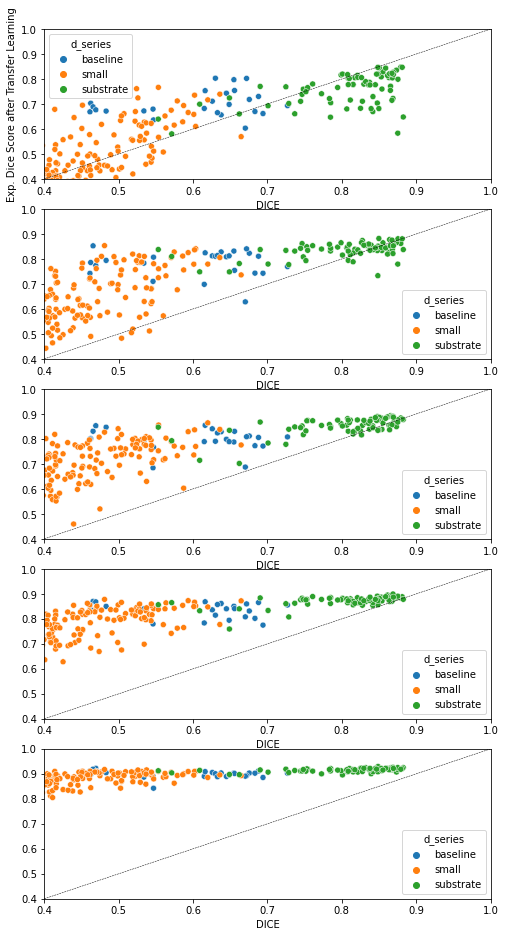

In [121]:
fig, axes = plt.subplots(5,1,figsize=(8,16))

splits = [0.8, 0.6, 0.5, 0.4, 0.2]
for i, ax in enumerate(axes):
    ax.set_xlabel("DICE")
    ax.set_xlim([0.4,1])
    ax.set_ylim([0.4,1])
    ax.plot([0,1],[0,1], linestyle="--", linewidth=0.5,color="k")
    sns.scatterplot(data=scatter_df[scatter_df["split"]==splits[i]], x="x_dice", y='y_dice', hue="d_series", ax=ax)
    ax.set_ylabel("")

axes[0].set_ylabel("Exp. Dice Score after Transfer Learning")

In [ ]:
fig, axes = plt.subplots(1,2,figsize=(10,8))

sns.scatterplot(data=scatter_df, x="x_dice", y='y_dice', hue="d_series", ax=axes[0])
sns.scatterplot(data=scatter_df, x="x_dice", y='y_dice', hue="split", palette="viridis",ax=axes[1])

for ax in axes:
    ax.set_xlabel("Exp. Dice Score after Synthetic Training")
    ax.set_ylabel("Exp. Dice Score after Transfer Learning")

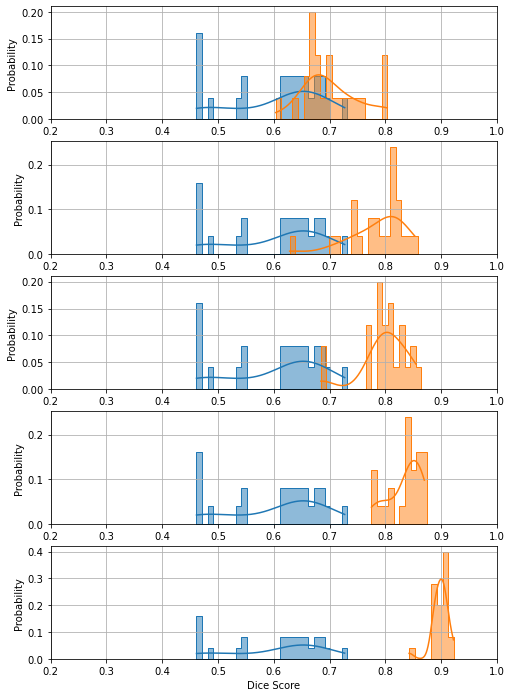

In [104]:
fig, axes = plt.subplots(5,1,figsize=(8,12))

style_args = {"kde":True,
              "binwidth":0.01,
              "stat":"probability",
              "element":"step"
              }

reduced_df = df[df["orig_model_ID"].isin(baseline_IDs)]
splits = [0.8, 0.6, 0.5, 0.4, 0.2]
for i in range(5):
    sns.histplot(data=df[df["series"]=="baseline"], x="exp_f1-score", ax=axes[i], **style_args)
    sns.histplot(data=reduced_df[reduced_df["expt_val_split"]==splits[i]], x="best_val_f1", color=cm.get_cmap("tab10")(1), ax=axes[i],**style_args)

for ax in axes:
    ax.set_xlabel("Dice Score")
    ax.grid()
    ax.set_xlim([0.2, 1.0])

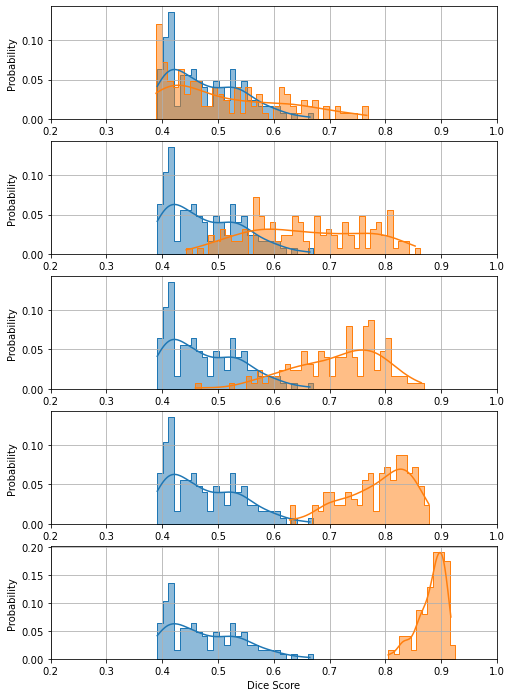

In [105]:
fig, axes = plt.subplots(5,1,figsize=(8,12))

style_args = {"kde":True,
              "binwidth":0.01,
              "stat":"probability",
              "element":"step"
              }

reduced_df = df[df["orig_model_ID"].isin(small_IDs)]
splits = [0.8, 0.6, 0.5, 0.4, 0.2]
for i in range(5):
    sns.histplot(data=df[df["series"]=="small"], x="exp_f1-score", ax=axes[i], **style_args)
    sns.histplot(data=reduced_df[reduced_df["expt_val_split"]==splits[i]], x="best_val_f1", color=cm.get_cmap("tab10")(1), ax=axes[i],**style_args)

for ax in axes:
    ax.set_xlabel("Dice Score")
    ax.grid()
    ax.set_xlim([0.2, 1.0])

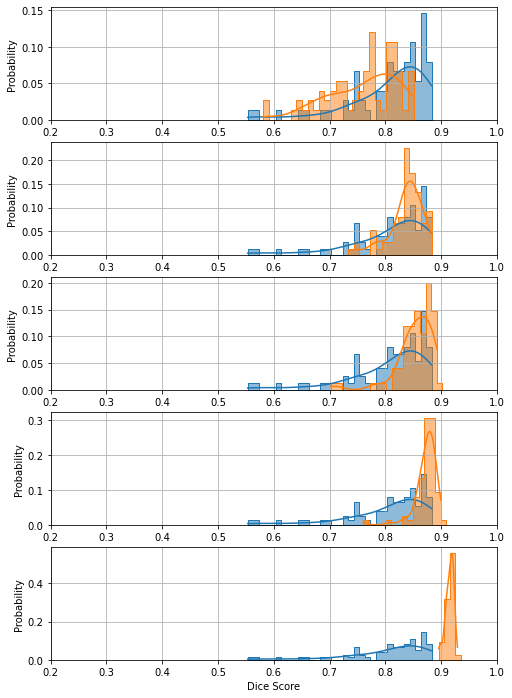

In [106]:
fig, axes = plt.subplots(5,1,figsize=(8,12))

style_args = {"kde":True,
              "binwidth":0.01,
              "stat":"probability",
              "element":"step"
              }

reduced_df = df[df["orig_model_ID"].isin(sub_IDs)]
splits = [0.8, 0.6, 0.5, 0.4, 0.2]
for i in range(5):
    sns.histplot(data=df[df["series"]=="substrate"], x="exp_f1-score", ax=axes[i], **style_args)
    sns.histplot(data=reduced_df[reduced_df["expt_val_split"]==splits[i]], x="best_val_f1", color=cm.get_cmap("tab10")(1), ax=axes[i],**style_args)

for ax in axes:
    ax.set_xlabel("Dice Score")
    ax.grid()
    ax.set_xlim([0.2, 1.0])

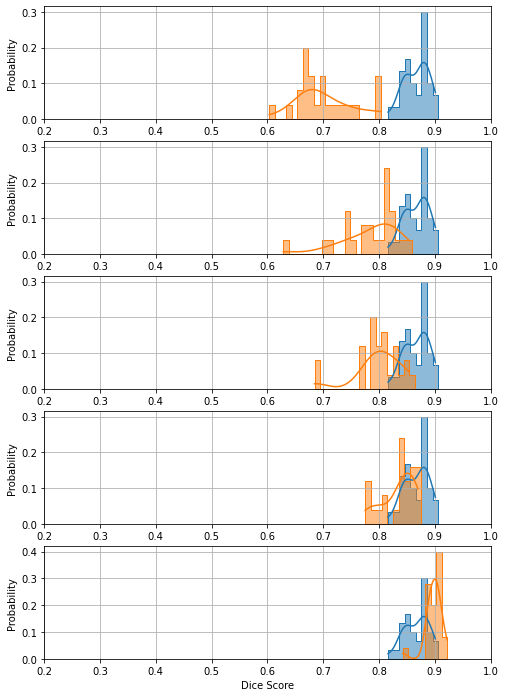

In [8]:
fig, axes = plt.subplots(5,1,figsize=(8,12))

style_args = {"kde":True,
              "binwidth":0.01,
              "stat":"probability",
              "element":"step"
              }

reduced_df = df[df["orig_model_ID"].isin(baseline_IDs)]
splits = [0.8, 0.6, 0.5, 0.4, 0.2]
for i in range(5):
    sns.histplot(data=df[df["series"]=="super"], x="exp_f1-score", ax=axes[i], **style_args)
    sns.histplot(data=reduced_df[reduced_df["expt_val_split"]==splits[i]], x="best_val_f1", color=cm.get_cmap("tab10")(1), ax=axes[i],**style_args)

for ax in axes:
    ax.set_xlabel("Dice Score")
    ax.grid()
    ax.set_xlim([0.2, 1.0])